# Template

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
import cv2

plt.style.use('science')
plt.rcParams.update({'font.size': 14})

# altes Mikroskop

## Messung 1

In [3]:
tubus_l = np.array([140, 150, 160, 170, 180])
dtubus_l = 0.5

len_div = 10 #mm
div_scale = 0.01 #mm
n1_division = [ # für 1 cm
    (20,20,21),
    (19,18,19),
    (18,17,17),
    (16,17,17),
    (16,16,16)
]

n1_div_bar = np.array([np.mean(i) for i in n1_division])
n1_div_std = np.array([np.std(i) / np.sqrt(3) for i in n1_division])

l = div_scale*n1_div_bar #mm
dl = div_scale*np.sqrt(n1_div_std**2 + 0.5**2)
#dl = div_scale*n1_div_std

V_ges = len_div / l
dV_ges = V_ges*(dl/l)
print(V_ges, dV_ges)

[49.18032787 53.57142857 57.69230769 60.         62.5       ] [1.37690819 1.63376128 1.8947764  2.04939015 1.953125  ]


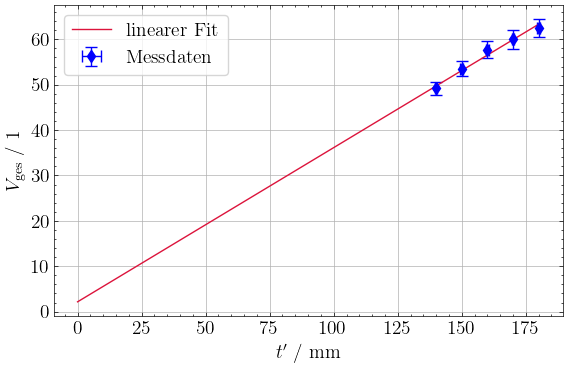

k: 0.3398661566310427 pm 0.05340391264310626
d: 2.149862442512089 pm 8.368274927763968


In [7]:
def ffit(t, k, d):
    return k*t + d

tubus_fit = np.linspace(0, 180, 1000)
popt, pcov = curve_fit(ffit, tubus_l, V_ges, sigma=dV_ges, absolute_sigma=True)
k, d = popt
dk, dd = np.sqrt(np.diag(pcov))
V_fit = ffit(tubus_fit, k, d)

plt.figure(figsize=(6,4))

plt.errorbar(tubus_l, V_ges, yerr=dV_ges, xerr=dtubus_l, fmt='d', color='blue', label='Messdaten', capsize=4)
plt.plot(tubus_fit, V_fit, linestyle='-', color='crimson', label='linearer Fit')

plt.xlabel(r"$t'$ / mm", fontsize=14) 
plt.ylabel(r'$V_{\text{ges}}$ / 1', fontsize=14)  
plt.legend(loc='best', fontsize=14, frameon=True)
plt.grid(True)

plt.tight_layout()
plt.show()
print(f'k: {k} pm {dk}')
print(f'd: {d} pm {dd}')

## Messung 2

In [8]:
tubus_l = np.array([140, 150, 160, 170, 180])
dtubus_l = 0.5

V_ok2 = 10 
div_scale = 0.01 #mm
n2_division = [ # für 1 cm
    (11,11,11),
    (10,10,11),
    (10, 9,10),
    ( 9, 9, 9),
    ( 9, 8, 8)
]

n2_div_bar = np.array([np.mean(i) for i in n2_division])
n2_div_std = np.array([np.std(i) / np.sqrt(3) for i in n2_division])

l = div_scale*n2_div_bar #mm
dl = div_scale*np.sqrt(n2_div_std**2 + 0.5**2)

V_ges = len_div / l
dV_ges = V_ges*(dl/l)
print(V_ges/V_ok2, dV_ges/V_ok2)
f_obj = V_ok2 * tubus_l/ V_ges
df_obj = f_obj*np.sqrt((dtubus_l/tubus_l)**2 + (dV_ges/V_ges)**2)
print(f_obj, df_obj)
print(np.mean(f_obj), np.sqrt(np.std(f_obj)**2 / len(f_obj) + np.mean(df_obj)**2))

[ 9.09090909  9.67741935 10.34482759 11.11111111 12.        ] [0.41322314 0.53314    0.60921229 0.61728395 0.81975606]
[15.4        15.5        15.46666667 15.3        15.        ] [0.70215739 0.8554742  0.91212156 0.85119034 1.02554186]
15.333333333333334 0.8730213556852561


# neues Mikroskop

## Messung 1 - Vergrößerung

In [ ]:
len_div = 10
div_scale = 0.01 #mm
n_neu_division = [ # für 1 cm
    (19,22,20),
    (9,8,9),     
    (2,2,2.5)  
]

n_neu_div_bar = np.array([np.mean(i) for i in n_neu_division])
n_neu_div_std = np.array([np.std(i) / np.sqrt(3) for i in n_neu_division])

l = div_scale*n_neu_div_bar #mm
dl = div_scale*n_neu_div_std

V_ges = len_div / l
dV_ges = V_ges*(dl/l)
print(V_ges, dV_ges)

[ 49.18032787 115.38461538 461.53846154] [ 1.74166641  3.62350554 28.98804429]


# digitales Mikroskop

## Liniengitter

In [10]:
l_klein = np.array([371676, 348044, 369528])/1000
l_groß  = np.array([708979, 672449, 700377])/1000

l_bar = (l_klein + l_groß) / 2
l = np.mean(l_bar)
dl = np.std(l_bar) / np.sqrt(3)
print(l, dl)
print(1/l *1000)

528.5088333333333 7.562440381154656
1.8921159627417141


## Graphene

In [9]:
def analyze_threshold(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Graphenbereiche blau färben, Hintergrund weiß
    blue_image = np.zeros((*binary.shape, 3), dtype=np.uint8)
    blue_image[binary == 0] = [0, 0, 200]  
    blue_image[binary != 0] = [240, 240, 240] 

    # Flächenanteil berechnen
    black_pixels = np.sum(binary == 0)
    total_pixels = binary.size
    percentage = (black_pixels / total_pixels) * 100

    plt.figure(figsize=(6, 4))
    plt.imshow(blue_image)
    plt.axis('off')
    plt.tight_layout()
    plt.figtext(0.5, 0.01, f'Flächenanteil Graphen: {percentage:.2f}%', ha='center', fontsize=20)
    plt.show()

    return percentage

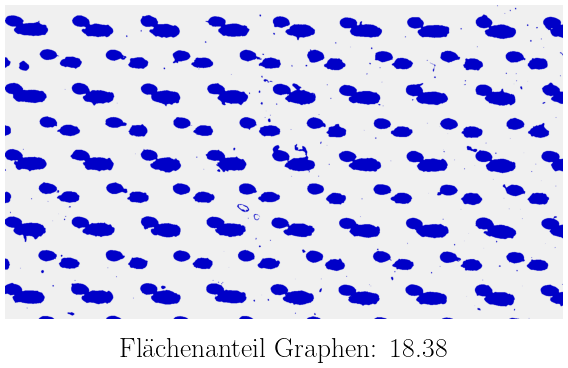

In [10]:
image_path = "/home/eudaemon/Workspace/Labor/Experimentalphysik2/10_Mikroskop/data/Graphene_20percent.jpg"

percentage2 = analyze_threshold(image_path)